# Note:  
V1 
- Create flow of modelling with KNN model.

In [57]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

seed_no = 572

import warnings
warnings.filterwarnings("ignore")

In [58]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Load data

In [59]:
df_trn = pd.read_csv('data/x_train_82.csv', index_col='index')
df_tst = pd.read_csv('data/x_test_82.csv', index_col='index')

In [60]:
print(df_trn.shape, df_tst.shape)
df_trn.head()

(847, 8) (212, 8)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,medium
824,6.8,45,0,0,0,1,255,medium
602,5.6,50,0,1,1,1,255,low
347,8.6,55,0,1,1,1,255,low
753,6.6,38,0,0,0,0,255,medium


# Preprocessing function

In [61]:
def encode_label(df_in):
    df_fnc = df_in.copy()
    df_fnc.loc[df_fnc['Grade']=='low', 'Grade'] = 0
    df_fnc.loc[df_fnc['Grade']=='medium', 'Grade'] = 1
    df_fnc.loc[df_fnc['Grade']=='high', 'Grade'] = 2
    df_fnc['Grade'] = df_fnc['Grade'].astype(int)
    
    return df_fnc

df_trn = encode_label(df_trn)
df_tst = encode_label(df_tst)

In [62]:
df_trn.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,1
824,6.8,45,0,0,0,1,255,1


In [63]:
# Prepare for training
y_trn = df_trn[['Grade']]
X_trn = df_trn.drop(columns='Grade')

y_tst = df_tst[['Grade']]
X_tst = df_tst.drop(columns='Grade')

print(y_trn.shape, X_trn.shape)
print(y_tst.shape, X_tst.shape)

(847, 1) (847, 7)
(212, 1) (212, 7)


In [64]:
## No scaller
X_trn_scale = X_trn
X_tst_scale = X_tst

# # Scaler
# scaler = StandardScaler()
# X_trn_scale = pd.DataFrame(scaler.fit_transform(X_trn))
# X_trn_scale.columns = X_trn.columns
# X_trn_scale.index = X_trn.index

# X_tst_scale = pd.DataFrame(scaler.transform(X_tst))
# X_tst_scale.columns = X_tst.columns
# X_tst_scale.index = X_tst.index

# scaler_norm = Normalizer()
# X_trn_scale = pd.DataFrame(scaler_norm.fit_transform(X_trn))
# X_trn_scale.columns = X_trn.columns
# X_trn_scale.index = X_trn.index

# X_tst_scale = pd.DataFrame(scaler_norm.transform(X_tst))
# X_tst_scale.columns = X_tst.columns
# X_tst_scale.index = X_tst.index


In [65]:
X_trn_scale.head(2)

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
index,,,,,,,
244,6.5,38,1,0,1,0,255
824,6.8,45,0,0,0,1,255


# Train model

## CV - Hyperparameters tuning

In [66]:
# Create a stratified 5-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_no)

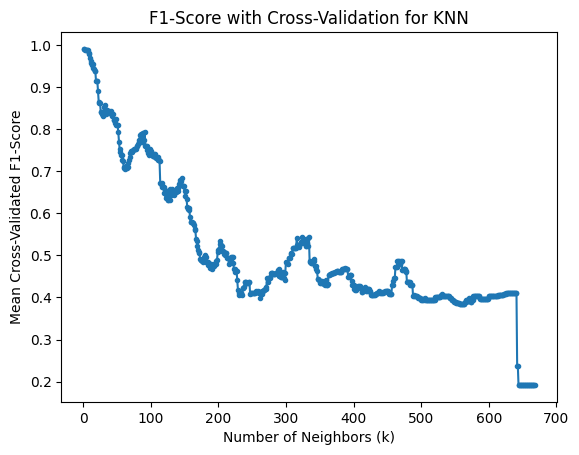

Optimal number of neighbors: 1


In [51]:
# Define a range of neighbors (k) to test
neighbors_range = range(1, int(X_trn_scale.shape[0]*0.79))

# Initialize an empty list to store mean cross-validated accuracies
cv_f1_scores = []
cv_f1_scores_std = []

# Perform cross-validation for each value of k
for k in neighbors_range:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, 
                             X_trn_scale, y_trn, 
                             cv=skf, scoring='f1_macro')
    f1_mean = np.mean(scores)
    f1_std = np.std(scores)
    cv_f1_scores.append(f1_mean)
    cv_f1_scores_std.append(f1_std)

# Plot the mean cross-validated accuracies for different values of k
plt.plot(neighbors_range, cv_f1_scores, marker='o', markersize=3)

plt.title('F1-Score with Cross-Validation for KNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validated F1-Score')
plt.show()

# Find the optimal number of neighbors (k) based on the elbow point
optimal_k = neighbors_range[np.argmax(cv_f1_scores)]
print("Optimal number of neighbors:", optimal_k)

## Retrain the whole training data with the best parameters

In [67]:
# Train model
## Create a KNN Classifier
# knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k, metric="manhattan", weights="uniform")
knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k)

## Train the model
knn_classifier.fit(X_trn_scale, y_trn)

## Make predictions on the test set
y_trn_pred = knn_classifier.predict(X_trn_scale)

## Evaluate the model/log score
dict_rep = classification_report(y_trn, y_trn_pred, output_dict=True)
print(classification_report(y_trn, y_trn_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00       299
           2       1.00      1.00      1.00       205

    accuracy                           1.00       847
   macro avg       1.00      1.00      1.00       847
weighted avg       1.00      1.00      1.00       847



## Performance on Test data

In [68]:
# Make predictions on the test set
# y_test_pred = rf_classifier.predict(X_tst)
y_test_pred = knn_classifier.predict(X_tst_scale)

# Evaluate the model
accuracy = accuracy_score(y_tst, y_test_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_tst, y_test_pred))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        51

    accuracy                           1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212



In [69]:
# Make predictions on the test set
# y_test_pred = rf_classifier.predict(X_tst)
y_test_pred = knn_classifier.predict(X_tst_scale)

# Evaluate the model
accuracy = accuracy_score(y_tst, y_test_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_tst, y_test_pred, digits=4))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        86
           1     1.0000    1.0000    1.0000        75
           2     1.0000    1.0000    1.0000        51

    accuracy                         1.0000       212
   macro avg     1.0000    1.0000    1.0000       212
weighted avg     1.0000    1.0000    1.0000       212



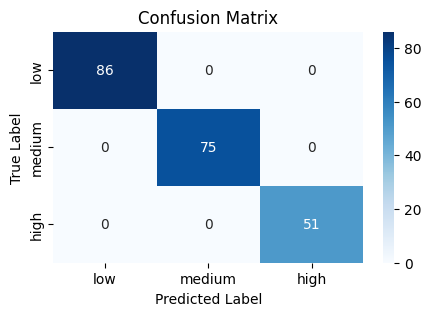

In [70]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_tst, y_test_pred)

# Display the confusion matrix using a heatmap
class_names = ['low', 'medium', 'high']
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# EDA Error (Testing dataset)

In [71]:
# Merge prediction with the testing dataset
df_test_perf = y_tst.copy()
df_test_perf['pred_test'] = y_test_pred
df_test_perf = X_tst.merge(df_test_perf, left_index=True, right_index=True)

# Explore Error
df_error = df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]
print(f"Number of False Prediction: {df_error.shape[0]} ({(100*df_error.shape[0]/y_tst.shape[0]):.02f}%)")
df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]

Number of False Prediction: 0 (0.00%)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade,pred_test
index,,,,,,,,,
